In [3]:
import sys
import pandas as pd
import numpy as np
import glob

import warnings
warnings.filterwarnings('ignore')
sys.path.append("../Moduulit/modules")
sys.path.append("../Datat/Mittaukset")
sys.path.append("../Datat/koskemattomat_csv")
sys.path.append("../Datat/csv")

### Luodataan dataseteille omat dataloaderit

In [4]:
from dataloaders import dataloaders

In [5]:
train_loader, test_loader, val_loader, large_test_loader= dataloaders('../Datat/csv/', False, False)

-------------------------------------------------------------
------------------ Creating Dataloaders ---------------------
-------------------------------------------------------------


Reading csv-files from ../Datat/csv//

Dataloaders:
train_loader: 6363 
test_loader: 1833 
val_loader: 1837 
large_test_loader: 10032


Done in 1.37 seconds.


### Luodaan ja koulutetaan verkko

In [6]:
import torch.nn as nn
from torch import optim
from neuroverkkomodel import neuroverkko
import torch
import matplotlib.pyplot as plt


In [7]:
model = nn.Sequential(nn.Linear(8, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,67),
                      nn.LogSoftmax(dim=1))
# criterion = nn.CrossEntropyLoss()
criterion = nn.MultiMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/7.. Step 800.. Train loss: 0.091.. Test loss: 0.093.. Test accuracy: 0.269
Epoch 1/7.. Step 1600.. Train loss: 0.020.. Test loss: 0.040.. Test accuracy: 0.332
Epoch 1/7.. Step 2400.. Train loss: 0.014.. Test loss: 0.033.. Test accuracy: 0.389
Epoch 1/7.. Step 3200.. Train loss: 0.011.. Test loss: 0.029.. Test accuracy: 0.475
Epoch 1/7.. Step 4000.. Train loss: 0.009.. Test loss: 0.025.. Test accuracy: 0.434
Epoch 1/7.. Step 4800.. Train loss: 0.008.. Test loss: 0.025.. Test accuracy: 0.399
Epoch 1/7.. Step 5600.. Train loss: 0.007.. Test loss: 0.014.. Test accuracy: 0.677
Epoch 2/7.. Step 6400.. Train loss: 0.007.. Test loss: 0.025.. Test accuracy: 0.417
Epoch 2/7.. Step 7200.. Train loss: 0.006.. Test loss: 0.023.. Test accuracy: 0.434
Epoch 2/7.. Step 8000.. Train loss: 0.006.. Test loss: 0.024.. Test accuracy: 0.550
Epoch 2/7.. Step 8800.. Train loss: 0.006.. Test loss: 0.029.. Test accuracy: 0.489
Epoch 2/7.. Step 9600.. Train loss: 0.005.. Test loss: 0.022.. Test accuracy:

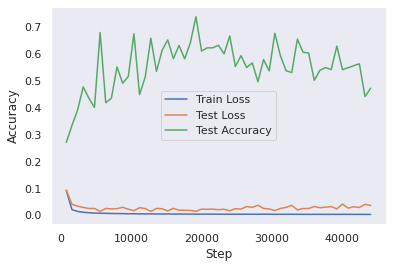

Haluatko tallentaa mallin? (y/n) y
enter the filename.pth clas_7e.pth


Done


564.6635789871216

In [46]:
import time
start = time.time()
neuroverkko(model, 3, optimizer, criterion, train_loader, val_loader)
time.time()-start

### Tarkastellaan miltä testisetin ennustukset näyttävät kuvaajalla

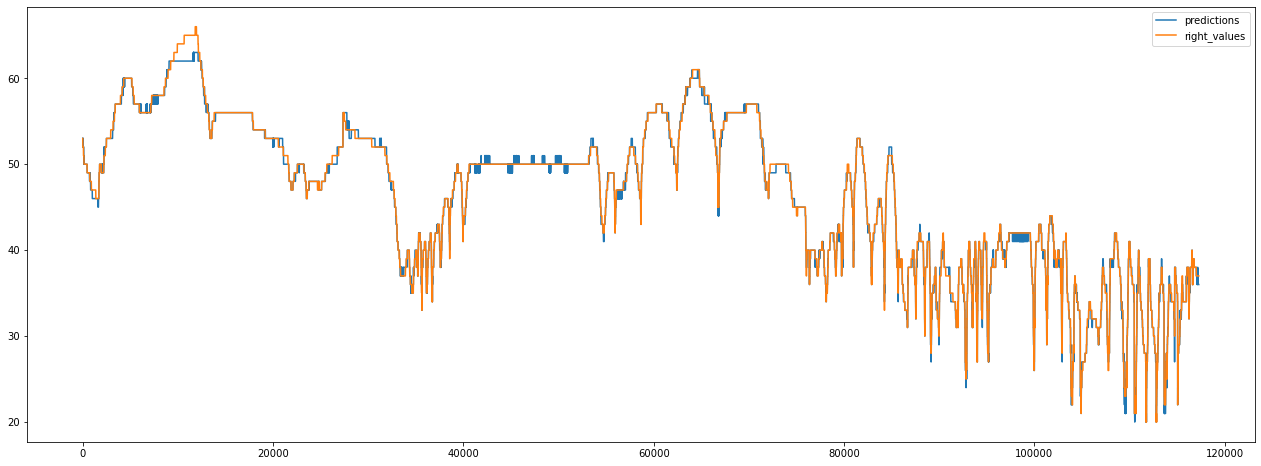

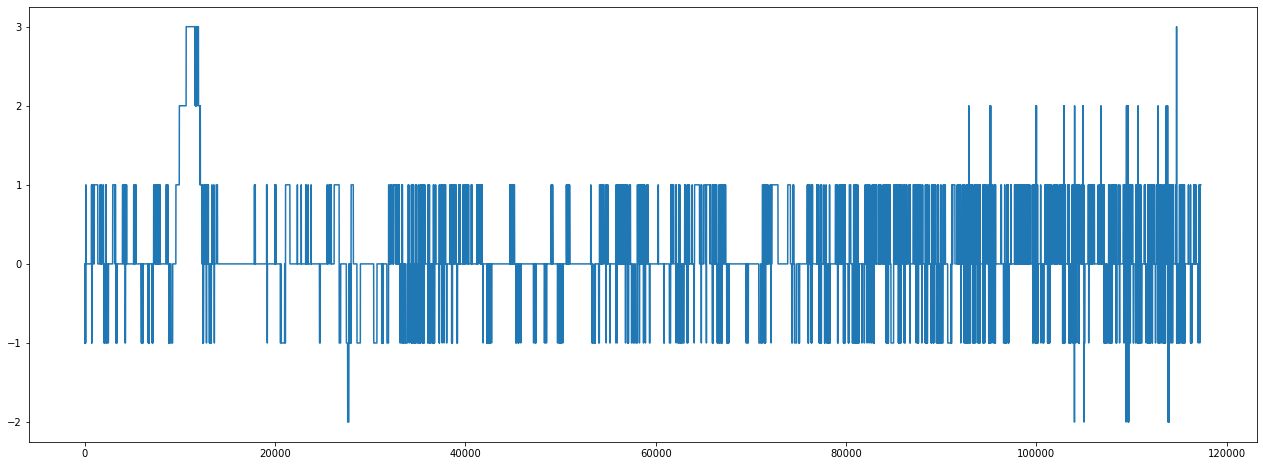

In [76]:

# model = torch.load("../Mallit/clas_7e.pth")   # Valmiiksi koulutetut mallit voidaan halutessa ladata:

predictions = []
right_values = []
values = []
with torch.no_grad():
    for inputs, targets in test_loader:

        targets = targets.squeeze()
        targets = targets.type(torch.LongTensor)
        logps = model(inputs.float())
#         print(targets)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == targets.view(*top_class.shape)

        for index, value in enumerate(equals):
            right_values.append(targets[index].item())
            values.append(inputs[index])
            predictions.append(top_class[index].item())

plt.figure(figsize=(22,8))
plt.plot(predictions, label='predictions')
plt.plot(right_values, label='right_values')
plt.legend()

plt.show()
plt.figure(figsize=(22,8))

plt.plot(np.array(np.array(right_values) - np.array(predictions)));
plt.show();

In [48]:
# Tarkkuus
np.count_nonzero(np.array(predictions)==np.array(right_values))/len(right_values)

0.7462244924063478

In [81]:
# Virheen keskihajonta
erotus = np.array(np.array(right_values) - np.array(predictions))
np.std(erotus)

0.5945246490501247

In [50]:
# suurin poitiivinen virhe
np.max(erotus)

3

In [51]:
# Suurin negatiivinen virhe
np.min(erotus)

-2